In [6]:
# | default_exp classification.mlclassifier

In [7]:
# | export
import numpy as np
import pandas as pd
import torch
from datasetsforecast.m4 import M4
from sklearn.preprocessing import LabelEncoder

ImportError: cannot import name 'pa_version_under7p0' from 'pandas.compat' (/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.11/lib/python3.11/site-packages/pandas/compat/__init__.py)

In [6]:
# ## Prepare data

# # Load Labels
# label_df = pd.read_parquet("data/evaluation_df.parquet").set_index("unique_id")["best_model"]

# # Load M4 dataset
# groups = ["Yearly", "Monthly", "Quarterly", "Hourly", "Weekly", "Daily"]
# m4_df_bucket = []
# for group in groups:
#     await M4.async_download("data", group=group)
#     Y_df, *_ = M4.load(directory="data", group=group)
#     m4_df_bucket.append(Y_df)
# m4_dataset = pd.concat(m4_df_bucket)

# m4_dataset = m4_dataset.sort_values(["unique_id", "ds"]).drop_duplicates(
#     subset=["unique_id", "ds"]
# )
# no_of_datapoints = m4_dataset.groupby("unique_id").apply(len).to_dict()

# # Convert to wide format (fixed)
# m4_dataset = m4_dataset.pivot(index="unique_id", columns="ds", values="y")

# # Merge with labels
# m4_dataset = m4_dataset.merge(label_df, left_index=True, right_index=True, how="right")

# best_model = m4_dataset["best_model"].to_dict()
# df_min = m4_dataset.drop("best_model", axis=1).min(axis=1)
# df_max = m4_dataset.drop("best_model", axis=1).max(axis=1)

# m4_dataset = (m4_dataset.drop("best_model", axis=1) - df_min.values.reshape(-1, 1)) / (
#     df_max - df_min
# ).values.reshape(-1, 1)

# m4_dataset["best_model"] = m4_dataset.index.map(best_model)
# m4_dataset["no_of_datapoints"] = m4_dataset.index.map(no_of_datapoints)

# m4_dataset.sort_values("no_of_datapoints", inplace=True)
# m4_dataset.drop("no_of_datapoints", axis=1, inplace=True)
# # clean up the memory
# del df_max
# del df_min
# del m4_df_bucket, no_of_datapoints

# # Encode categorical labels
# le = LabelEncoder()
# m4_dataset["best_model"] = le.fit_transform(m4_dataset["best_model"])
# m4_dataset.columns = m4_dataset.columns.astype(str)

# # Save as optimized Parquet
# m4_dataset.to_parquet(
#     "data/m4_preprocessed.parquet", engine="fastparquet", compression="snappy"
# )

# print("✅ Preprocessing Complete! Data saved as Parquet.")

In [7]:
df = pd.read_parquet("data/m4_preprocessed.parquet")
df.drop_duplicates(inplace=True)

In [8]:
# AUTOGENERATED! DO NOT EDIT! File to edit: ../../nbs/src/commons.stats.ipynb.

# %% auto 0
__all__ = ["ensure_tensor", "extract_stats_features"]

from itertools import groupby

import antropy as ant
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

# %% ../../nbs/src/commons.stats.ipynb 1
import torch
from nolds import dfa, hurst_rs
from scipy.fftpack import fft
from scipy.signal import find_peaks, welch
from scipy.stats import variation
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

# import PyWavelets

# %% ../../nbs/src/commons.stats.ipynb 2
# Ensure tensor input


def ensure_tensor(series):
    if isinstance(series, pd.Series):
        return torch.tensor(series.values, dtype=torch.float32)
    elif isinstance(series, np.ndarray):
        return torch.tensor(series, dtype=torch.float32)
    elif isinstance(series, torch.Tensor):
        return series.float()
    else:
        raise ValueError("Input must be a pandas Series, NumPy array, or PyTorch tensor")


# Feature extraction function


def extract_stats_features(series, max_lag=10):
    series = ensure_tensor(series)
    series_np = series.cpu().numpy()

    features = {}

    # Basic Stats
    features["mean"] = torch.mean(series).item()
    features["std"] = torch.std(series).item()
    features["var"] = torch.var(series).item()
    features["skewness"] = stats.skew(series_np)
    features["kurtosis"] = stats.kurtosis(series_np)
    features["min"] = torch.min(series).item()
    features["max"] = torch.max(series).item()
    features["range"] = features["max"] - features["min"]
    features["median"] = torch.median(series).item()
    features["iqr"] = np.percentile(series_np, 75) - np.percentile(series_np, 25)
    features["mad"] = torch.median(torch.abs(series - torch.median(series))).item()
    features["cv"] = variation(series_np)

    # Normality Tests
    _, features["shapiro_p"] = stats.shapiro(series_np)
    _, features["ks_p"] = stats.kstest(series_np, "norm")
    _, features["jarque_bera_p"] = stats.jarque_bera(series_np)

    # Stationarity Tests
    features["adf_p"] = adfuller(series_np)[1]
    features["kpss_p"] = kpss(series_np, regression="c")[1]

    # Autocorrelation
    acf_values = acf(series_np, nlags=max_lag)
    pacf_values = pacf(series_np, nlags=max_lag)
    for lag in range(1, max_lag + 1):
        features[f"acf_{lag}"] = abs(acf_values[lag])
        features[f"pacf_{lag}"] = abs(pacf_values[lag])

    # Ljung-Box Test for white noise
    features["ljungbox_p"] = abs(acorr_ljungbox(series_np, lags=[1]).iloc[0, 1])

    # Fourier Transform (Dominant Frequency)
    fft_values = np.abs(fft(series_np))
    features["fft_peak"] = np.max(fft_values)

    # Power Spectral Density (PSD) peak
    freqs, psd = welch(series_np)
    features["psd_peak"] = np.max(psd)

    # Hurst Exponent
    features["hurst_exponent"] = hurst_rs(series_np)
    features["dfa"] = dfa(series_np)

    # Sparsity Measure
    features["sparsity"] = np.sum(series_np == 0) / len(series_np)

    # Entropy Measures
    features["perm_entropy"] = ant.perm_entropy(series_np)
    features["spectral_entropy"] = ant.spectral_entropy(series_np, sf=1.0)
    features["svd_entropy"] = ant.svd_entropy(series_np)
    features["approx_entropy"] = ant.app_entropy(series_np)
    features["sample_entropy"] = ant.sample_entropy(series_np)

    # Change-point detection
    peaks, properties = find_peaks(series_np, prominence=1)
    features["num_peaks"] = len(peaks)
    features["peak_prominence_mean"] = (
        np.mean(properties["prominences"]) if len(properties["prominences"]) > 0 else 0
    )

    # Trend and Seasonality
    stl = seasonal_decompose(series_np, period=13)
    features["sd_trend_std"] = np.std(stl.trend)
    features["sd_seasonal_std"] = np.std(stl.seasonal)
    features["sd_resid_std"] = np.std(stl.resid)

    # Trend and Seasonality
    stl = STL(series_np, period=13).fit()
    features["stl_trend_std"] = np.std(stl.trend)
    features["stl_seasonal_std"] = np.std(stl.seasonal)
    features["stl_resid_std"] = np.std(stl.resid)

    # Longest flat segment
    features["longest_flat_segment"] = max(
        [len(list(g)) for k, g in groupby(series_np) if k == 0], default=0
    )

    # # Wavelet Transform Features
    # coeffs = PyWavelets.wavedec(series_np, 'db4', level=3)
    # features['wavelet_energy'] = sum(np.sum(np.abs(c)**2) for c in coeffs)
    # features['wavelet_entropy'] = stats.entropy(np.hstack(coeffs))

    # Higher Order Moments
    features["mean_abs_change"] = np.mean(np.abs(np.diff(series_np)))
    features["longest_positive_run"] = max(
        [sum(1 for _ in g) for k, g in groupby(series_np > 0) if k], default=0
    )

    return pd.Series(features)

<Axes: ylabel='Density'>

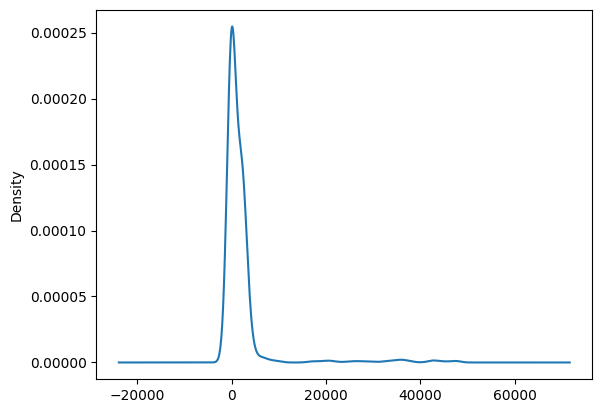

In [18]:
df.drop("best_model", axis=1).apply(lambda series: series.dropna().values).map(len)

In [17]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.2 MB/s eta 0:00:0031m11.6 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
from pycaret.classification import *

s = setup(df, target="best_model", session_id=123)

,Description,Value
0,Session id,123
1,Target,best_model
2,Target type,Multiclass
3,Original data shape,"(47752, 9934)"
4,Transformed data shape,"(47752, 7857)"
5,Transformed train set shape,"(33426, 7857)"
6,Transformed test set shape,"(14326, 7857)"
7,Numeric features,9933
8,Rows with missing values,100.0%
9,Preprocess,True


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.3 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 11.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 11.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 9.7 MB/s eta 0:00:000m eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
  